In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchmetrics import Accuracy
from tqdm import tqdm


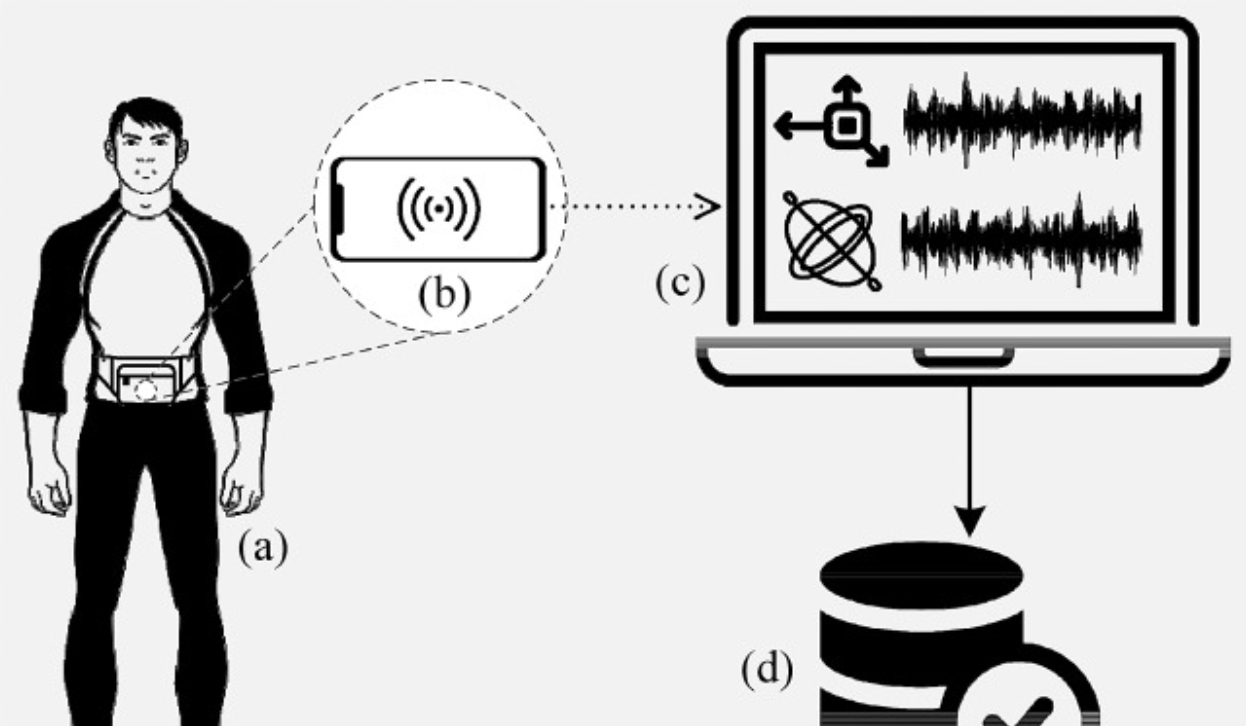

In [5]:
!unzip UCI_HAR_Dataset.zip

Archive:  UCI_HAR_Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating: UCI HAR

In [6]:
import glob
for file in glob.glob("/content/UCI HAR Dataset/train/Inertial Signals/*"):
  print(file)

/content/UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_gyro_z_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_acc_y_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt


In [7]:
train_data = []
for file in glob.glob("/content/UCI HAR Dataset/train/Inertial Signals/*"):
  train_data.append(np.loadtxt(file))

In [8]:
torch.tensor(train_data).shape

<ipython-input-8-b9fc7ee74b81>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  torch.tensor(train_data).shape


torch.Size([9, 7352, 128])

In [12]:
torch.tensor(train_data).permute(1, 2, 0).shape

torch.Size([7352, 128, 9])

In [31]:
y_train = np.loadtxt("/content/UCI HAR Dataset/train/y_train.txt")
y_train

array([5., 5., 5., ..., 2., 2., 2.])

In [137]:
def har_dataset(phase):
  x = []
  data_dir = f'/content/UCI HAR Dataset/{phase}/Inertial Signals/*'
  for file_dir in glob.glob(data_dir):
    x.append(np.loadtxt(file_dir))
  y = np.loadtxt(f'/content/UCI HAR Dataset/{phase}/y_{phase}.txt')
  #
  x = torch.FloatTensor(x).permute(1, 2, 0)
  y = torch.LongTensor(y) - 1
  return x, y

In [138]:
x_train, y_train = har_dataset('train')
x_test, y_test = har_dataset('test')

In [40]:
y_train.unique()

tensor([0, 1, 2, 3, 4, 5])

In [54]:
x_train.shape, y_train.shape

(torch.Size([7352, 128, 9]), torch.Size([7352]))

In [55]:
x_test.shape, y_test.shape

(torch.Size([2947, 128, 9]), torch.Size([2947]))

In [56]:
train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)

In [140]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [58]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([64, 128, 9])
torch.Size([64])


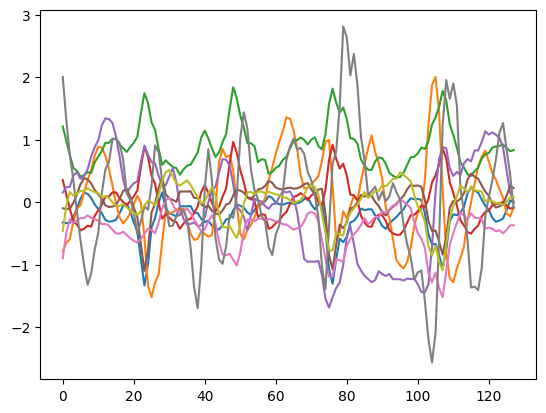

In [22]:
plt.plot(x[0])

In [125]:
model = nn.RNN(input_size=9, hidden_size=32, num_layers=1,
       nonlinearity='tanh', bias=True, batch_first=True, dropout=0.,
       bidirectional=False)

In [64]:
outputs, hn = model(x)

In [65]:
print(hn.shape)
print(outputs.shape)

torch.Size([1, 64, 32])
torch.Size([64, 128, 32])


In [66]:
class RNNModel(nn.Module):
  def __init__(self, ):
    super().__init__()
    pass

  def forward(self, x):
    return y

In [141]:
class RNNModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, bidirectional, num_cls):
    super().__init__()
    self.rnn = nn.RNN(input_size=input_size,
                      hidden_size=hidden_size,
                      num_layers=num_layers,
                      bidirectional=bidirectional,
                      batch_first=True)

    self.fc = nn.Linear(hidden_size,num_cls)

  def forward(self, x):
    outputs,hn = self.rnn(x)
    y = self.fc(outputs[:, -1])
    y = y.mean(dim=1)
    return y

In [142]:
model = RNNModel(9, 32, 1, False, 6)
model

RNNModel(
  (rnn): RNN(9, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=6, bias=True)
)

In [128]:
model(x).shape

torch.Size([64])

In [129]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [143]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None,num_class=6):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task = 'multiclass',num_classes=num_class).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy().to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

In [144]:
model = RNNModel(9, 32, 1, False, 6).to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

RuntimeError: ignored

In [131]:
num_epochs = 5
for lr in [0.9, 0.5, 0.2, 0.1, 0.01, 0.001]:
  print(f'LR={lr}')
  model = RNNModel(9, 32, 1, False, 6).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

LR=0.9


Epoch 0:   0%|          | 0/115 [00:00<?, ?batch/s]


RuntimeError: ignored